In [365]:
### RBN: 18 Aug 2020: Set up panel plots that can selectively plot full field, obs., bias, and run differences. ###

import numpy as np
import xarray as xr
import pandas as pd

from metpy.interpolate import log_interpolate_1d
from metpy.units import units

import matplotlib.pyplot as mp
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.basemap import Basemap as bmap
import matplotlib as mpl

import cartopy
import cartopy.crs as ccrs
import cartopy.util as cutil
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from sys import exit


%xmode Plain   ## Fortran-like error tracebacks

Exception reporting mode: Plain


<p style="color:violet;">Variable, Case, Season and Plot Type Options

In [366]:
# Set up case/data variables

dir_root = '/glade/p/cgd/amp/people/hannay/amwg/climo/'

ldiff_ctrl = True # Difference compared to the control?
seas = 'JJA'


var_name = 'U200'
## Cases to focus on

#PRECT
case_desc = np.array(['C6','rC5','rUW','rUWp','rMG1','rpfrac','rTMS','C5','rZMc'])

nrow = 3 ; ncol = 3 # Rows and columns
#SWCF
#case_desc = np.array(['C6','rC5','rUW','rUWp','rMG1','rpfrac','rice','rC5pm','rZMc'])

#LWCF
#case_desc = np.array(['C6','rC5','rUW','rUWp','rMG1','rpfrac','rice','rC5pm','rZMc'])
#case_desc = np.array(['C6','rC5','rCE2i',])
#case_desc = np.array(['C6','rC5t','rC5','rZMc'])

# #of contour intervals
ncint = 10
ancint = 20


<p style="color:violet;">Case and Variable Options, with Attributes

In [367]:
# List of case info.

cases_df = cam_revert_list()

ncases = case_desc.size

# List of variable info.

pvars = {}

pvars['PRECT']  = ['Precipitation','mm/day','2d','x','x',
    86400.*1000,2.,20.,-10.,10.,'terrain_r','PRGn']
pvars['LHFLX']  = ['Surface Latent Heat Flux','W/m^2','2d','x','x',
    1,100.,300.,-100.,100.,'PuBuGn','PRGn']
pvars['SWCF']   = ['Short Wave Cloud Forcing','W/m^2','2d','x','x',
    1.,-150,0.,-60.,60.,'PuBu_r','RdBu_r']
pvars['LWCF']   = ['Long Wave Cloud Forcing','W/m^2','2d','x','x',
    1.,0,100.,-30.,30.,'Reds','RdBu_r']
pvars['CLDTOT'] = ['Total Cloud','%','2d','x','x',
    100.,0,100.,-30.,30.,'PuBuGn','PRGn']

pvars['T800']   = ['800-mb Temperature','m/s','3d','T',800.,
    1.,0,100.,-30.,30.,'PuBuGn','PRGn']
pvars['Z500']   = ['500-mb Geopotential Height','m','3d','Z3',500.,
    1.,0,100.,-30.,30.,'PuBuGn','PRGn']
pvars['U200']   = ['200-mb Zonal Wind','m/s','3d','U',200.,
    1.,0,100.,-30.,30.,'PuBuGn','PRGn']
pvars['U850']   = ['850-mb Zonal Wind','m/s','3d','U',850.,
    1.,0,30.,-10.,10.,'PuBuGn','PRGn']
pvars['U10']    = ['10-m Wind Speed','m/s','2d','x','x',
    1.,0,10.,-5.,5.,'PuBuGn','PRGn']
pvars['TAUX']    = ['Surface Zonal Stress','m/s','2d','x','x',
    1.,-0.4,0.4,-0.1,0.1,'PRGn','PRGn']


<p style="color:violet;"> Determine if 3D fields are required from the climo. files

In [368]:
pvars_df = pd.DataFrame.from_dict(pvars, orient='index',columns=['long name','munits','dim_num','3d_var','pres_lev','mscale','cmin','cmax','acmin','acmax','cmap','acmap'])
print(pvars_df)

var_name_in = var_name # Could ultimately be different from var_name as 3D variable might be required. 

### Do we need to find a p-level variable from 
# list out keys and values separately 

dim_var_file = pvars_df.loc[var_name]['dim_num'] 

l3d_var = True if '3d' in dim_var_file else False

#### Construct 2D pressure filed from 3d history file field ##
if l3d_var:    
    var_name_in = pvars_df.loc[var_name]['3d_var'] # Which 3D variable is need for this field? 
    plev_val = pvars_df.loc[var_name]['pres_lev']
    print('** ',var_name,' will be calculated from 3d variable ',var_name_in,' **')    
    
else :
    print('** ',var_name,' available on history file, no pressure interpolation required **')
    

                         long name  munits dim_num 3d_var pres_lev  \
PRECT                Precipitation  mm/day      2d      x        x   
LHFLX     Surface Latent Heat Flux   W/m^2      2d      x        x   
SWCF      Short Wave Cloud Forcing   W/m^2      2d      x        x   
LWCF       Long Wave Cloud Forcing   W/m^2      2d      x        x   
CLDTOT                 Total Cloud       %      2d      x        x   
T800            800-mb Temperature     m/s      3d      T      800   
Z500    500-mb Geopotential Height       m      3d     Z3      500   
U200             200-mb Zonal Wind     m/s      3d      U      200   
U850             850-mb Zonal Wind     m/s      3d      U      850   
U10                10-m Wind Speed     m/s      2d      x        x   
TAUX          Surface Zonal Stress     m/s      2d      x        x   

            mscale   cmin   cmax  acmin  acmax       cmap   acmap  
PRECT   86400000.0    2.0   20.0  -10.0   10.0  terrain_r    PRGn  
LHFLX          1.0  100

<p style="color:violet;">Initialize Graphics Choices<\color>

+++++ Plotting +++++
# cases =  9


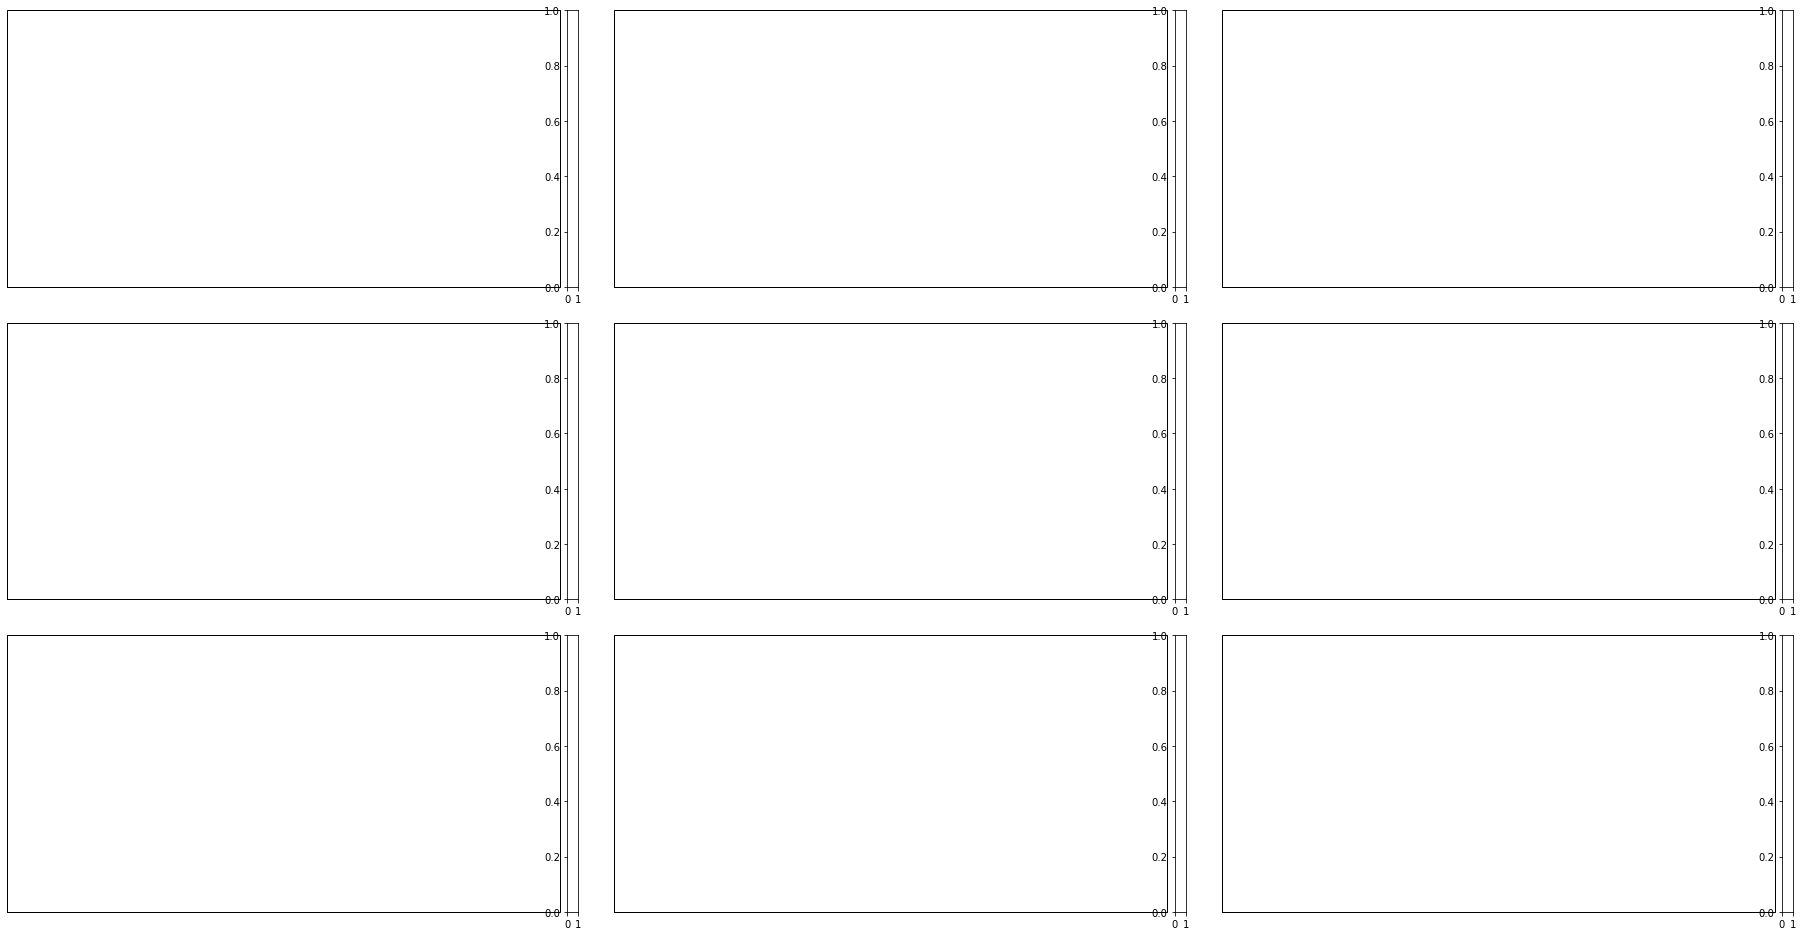

In [369]:
# Grab/Process data
mscale = pvars_df.loc[var_name]['mscale']
# Set up graphics
#pproj = ccrs.Mollweide(central_longitude=0.0)
pproj = ccrs.PlateCarree(central_longitude=180.0)
#pproj = ccrs.EckertV(central_longitude=-180.)


axes_class = (GeoAxes,dict(map_projection=pproj))

#mp.rcParams["mpl_toolkits.legacy_colorbar"] = False
fig = mp.figure(figsize=(32, 20))

axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(nrow, ncol),
                    axes_pad=0.5,
                    share_all=True,
                    cbar_location='right',
                    cbar_mode='each',
                    cbar_pad=0.1,
                    cbar_size='2%',
                    label_mode='')  # note the empty label_mode

# Contouring choices #

cmin = pvars_df.loc[var_name]['cmin'] ; cmax = pvars_df.loc[var_name]['cmax']
acmin = pvars_df.loc[var_name]['acmin']; acmax = pvars_df.loc[var_name]['acmax']

dcont = (cmax-cmin)/ncint ; adcont = (acmax-acmin)/ancint

plevels =  np.arange(cmin,cmax+dcont,dcont,dtype=np.float)
aplevels = np.arange(acmin,acmax+adcont,adcont,dtype=np.float)

if var_name == 'PRECT':
    plevels = np.array([1,2,3,4,5,8,10,12,15,20,25,30])
    aplevels = np.array([-15,-12,-8,-6,-4,-3,-2,-1,1,2,3,4,6,8,12,15])
    
### Does var require interpolation from 3D? ##


ncases = case_desc.size

print('+++++ Plotting +++++')
print('# cases = ',ncases)
      
nplots = nrow*ncol
if ncases != nplots: 
    print('')
    print('*** nrow*ncol does not mathc ncases - exiting ***') 
    exit('nplot,ncase mi-match')
      
pvar_ctrl = None

In [370]:
###################################
#### LOOP Cases and Subfigures ####
###################################


for icase, ax in enumerate(axgr):
    pvar = None # Reset
   
    cdesc = case_desc[icase]
    cname = cases_df.loc[cdesc]['run name']
    mscale = pvars_df.loc[var_name]['mscale']      
    
    file_in = dir_root+cname+'/0.9x1.25/'+cname+'_'+seas+'_climo.nc'
    
    print('')
    print(cdesc+' - '+cname)
    print('-File = '+file_in)
    print('')
    
    case_nc = xr.open_dataset(file_in,engine='netcdf4')
    
## Read in variable data ##   
   
# Composite variables #
    if var_name == 'PRECT': 
        pvar = case_nc['PRECC'].isel(time=0)+case_nc['PRECL'].isel(time=0) 
        
# Interpolated from 3D variable # 

    if l3d_var: 
        print('++ Interpolating from 3D field ##')
#        temperature = units.Quantity(data.variables[var_name_in], '')
        pvar3d = case_nc[var_name_in].isel(time=0) # Read in 3D variable
#        pvar3d = units.Quantity(case_nc[var_name_in])
        pvar3d.squeeze()
        print(pvar3d)
        print('')
        pres_levu = plev_val * units.hPa
        
        ps,P0,hyam,hybm =  case_nc['PS'].isel(time=0),case_nc['P0'],case_nc['hyam'],case_nc['hybm']
        pres_lev = hyam*P0 + hybm*ps
        pres_lev.squeeze()
        print(pres_lev)
        
        pvar = log_interpolate_1d(plev_val, pres_lev, pvar3d, axis=0)
        print(pvar)

# Standard 2D variable read.
    if pvar is None: 
        pvar = case_nc[var_name_in].isel(time=0).squeeze()
   
    pvar = mscale*pvar # Scale to useful units.
 
    lon = case_nc['lon']   
    lat = case_nc['lat']
   
## Retain control case data ##   
    if pvar_ctrl is None: pvar_ctrl = pvar
    
## Contouring (full or anom) ##

    clevels = plevels   
    cmap = pvars_df.loc[var_name]['cmap']      
   
    
## Modify if anom plot ##   
    
   
    if icase > 0 & ldiff_ctrl:

# I think CAM5 coords are slighly misalligned so have to interpolate to the pvar_ctrl (mostly CAM6/C6)
        pvar = pvar.interp(lat=pvar_ctrl.lat,lon=pvar_ctrl.lon) if cdesc == 'C5' else pvar
        pvar = np.subtract(pvar,pvar_ctrl)
        clevels = aplevels[abs(aplevels) > 1.e-15] # Remove zero contour, but somtimes it can be very small as well.
        cmap = pvars_df.loc[var_name]['acmap'] 
    
   
## Plotting for each ax ##  
# Domain, this seems flakey for cartopy ##

    ax.set_extent([1, 360, -40., 60.], crs=pproj)
    ax.coastlines()

## Namings ##
    ax.set_title(cdesc, x=0.01, y=0.05,fontweight ="bold",fontsize = 22,
                 horizontalalignment='left',backgroundcolor = 'white')


## Add Cyclic Point ##   
    pvarc,lonc = cutil.add_cyclic_point(pvar,coord=lon)
   
## Translate to -180->+180 - maddening
    pvarc = np.roll(pvarc, 144, axis=1) # 144 points will roll you from 0-360 ->-180-180 data   \    
    pvarcf = pvarc 
  
## Contour plot
    pplot = ax.contourf(lonc, lat, pvarcf,transform=pproj
        ,levels=clevels,cmap=cmap, extend='both')
    
# Colorbars
    axgr.cbar_axes[icase].colorbar(pplot) # Plot individual color bars befor line contour screws it up!
    pplot = mpl.colorbar.ColorbarBase(axgr.cbar_axes[icase], cmap=cmap,
                               boundaries=clevels,
                               orientation='vertical')
## Line plot
    pplot = ax.contour (lonc, lat, pvarcf,transform=pproj
        ,levels=clevels,colors='black',linewidths=0.5)
   
    
## Contour labaling ##
    ax.clabel(
        pplot,  # Typically best results when labelling line contours.
        colors=['black'],
        manual=False,  # Automatic placement vs manual placement.
        inline=True,  # Cut the line where the label will be placed.
        fmt=' {:.0f} '.format,  # Labels as integers, with some extra space.
    )
    del(pvar,lon,lonc)
    
mp.savefig('CAM6_oview_'+var_name+'_'+seas+'.png', dpi=300)


C6 - f.e20.FHIST.f09_f09.cesm2_1.001
-File = /glade/p/cgd/amp/people/hannay/amwg/climo/f.e20.FHIST.f09_f09.cesm2_1.001/0.9x1.25/f.e20.FHIST.f09_f09.cesm2_1.001_JJA_climo.nc

++ Interpolating from 3D field ##
<xarray.DataArray 'U' (lev: 32, lat: 192, lon: 288)>
[1769472 values with dtype=float32]
Coordinates:
    time     object 1965-07-05 23:28:58
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    mdims:         1
    units:         m/s
    long_name:     Zonal wind
    cell_methods:  time: mean

<xarray.DataArray (lev: 32, lat: 192, lon: 288)>
array([[[   364.346569,    364.346569, ...,    364.346569,    364.346569],
        [   364.346569,    364.346569, ...,    364.346569,    364.346569],
        ...,
        [   364.346569,    364.346569, ...,    364.346569,    364.346569],
        

TypeError: Input z must be a 2D array.

In [ ]:
#####################################
# CAM6 Revert Experiments + others   
#####################################


def cam_revert_list():
	

    rl = {} # Revert List
# Releases
    rl['C4']   =  ['f40.1979_amip.track1.1deg.001']
    rl['C5']   =  ['30L_cam5301_FAMIP.001']
    rl['C6']   =  ['f.e20.FHIST.f09_f09.cesm2_1.001']
    rl['CC4']  =  ['b40.20th.track1.1deg.012']
    rl['CE1']  =  ['b.e11.B20TRC5CNBDRD.f09_g16.001']
    rl['CE2']  =  ['b.e21.BHIST.f09_g17.CMIP6-historical.001']

    # Reverts
    rl['rC5now']  =   ['f.e20.FHIST.f09_f09.cesm2_1_cam5.001']
    rl['rC5']     =   ['f.e20.FHIST.f09_f09.cesm2_1_true-cam5.001']
    rl['rC5t']    =   ['f.e20.FHIST.f09_f09.cesm2_1_true-cam5_param_topo.001']
    rl['rUWold']  =   ['f.e20.FHIST.f09_f09.cesm2_1_uw.001']
    rl['rGW']    =   ['f.e20.FHIST.f09_f09.cesm2_1_iogw.001']
    rl['rZMc']  =   ['f.e20.FHIST.f09_f09.cesm2_1_capeten.001']
    rl['rMG1']  =   ['f.e20.FHIST.f09_f09.cesm2_1_mg1.001']
    rl['rSB']  =   ['f.e20.FHIST.f09_f09.cesm2_1_sb.002']
    rl['rTMS']  =   ['f.e20.FHIST.f09_f09.cesm2_1_tms.001']
    rl['rCE2i']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revert125.001']
    rl['rC5p']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertcam5param.001']
    rl['rC5pm']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertcam5param.002']
    rl['rZMp']  =   ['f.e20.FHIST.f09_f09.cesm2_1_cam5_zmconv.001']
    rl['rM3']  =   ['f.e20.FHIST.f09_f09.cesm2_1_mam3.001']
    rl['rUW']  =   ['f.e20.FHIST.f09_f09.cesm2_1_uw.002']
    rl['rUWp']  =   ['f.e20.FHIST.f09_f09.cesm2_1_uw.003']
    rl['rMG1ii']  =   ['f.e20.FHIST.f09_f09.cesm2_1_mg1.002']
    rl['rice']  =   ['f.e20.FHIST.f09_f09.cesm2_1_ice-micro.001']
    rl['rpfrac']  =   ['f.e20.FHIST.f09_f09.cesm2_1_precip_frac_method.001']
    rl['rpremit']  =   ['f.e20.FHIST.f09_f09.cesm2_1_cld_premit.001']
    rl['rC5psalt']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertc5seasalt.001']
    rl['rC5pdust']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertc5dust.001']
    rl['rL30']  =   ['f.e20.FHIST.f09_f09.cesm2_1_L30.001']
    
# SST configs    
    rl['CE2sst']  =   ['f.e20.FHIST.f09_f09.cesm2_1_coupled-sst-amip.001']

# Data frame
    rl_df = pd.DataFrame.from_dict(rl, orient='index',columns=['run name'])
    return rl_df

In [310]:
#Spare code - Mostly graphics
   
## Ticks and axes if needed ##

#    ax.set_xticks(np.linspace(-180., 180, 5), crs=pproj)
#    ax.set_yticks(np.linspace(-45, 45, 5), crs=pproj)
#    lon_formatter = LongitudeFormatter(zero_direction_label=True)
#    lat_formatter = LatitudeFormatter()
#    ax.xaxis.set_major_formatter(lon_formatter)
#    ax.yaxis.set_major_formatter(lat_formatter)

## Just tset everything global    
#    ax.set_global()

#    ax.set_ylabel('Latitude') 
#    ax.set_xlabel('Longitude')  

